In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [117]:
amd = pd.read_csv('Data/AMD (1980-2023).csv')

In [118]:
amd

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-18,0.000000,3.125000,2.937500,3.031250,3.031250,727200
1,1980-03-19,0.000000,3.083333,3.020833,3.041667,3.041667,295200
2,1980-03-20,0.000000,3.062500,3.010417,3.010417,3.010417,159600
3,1980-03-21,0.000000,3.020833,2.906250,2.916667,2.916667,130800
4,1980-03-24,0.000000,2.916667,2.635417,2.666667,2.666667,436800
...,...,...,...,...,...,...,...
10854,2023-04-05,94.349998,94.500000,91.360001,92.559998,92.559998,52979300
10855,2023-04-06,91.470001,92.910004,90.620003,92.470001,92.470001,47778400
10856,2023-04-10,91.320000,95.800003,91.019997,95.480003,95.480003,52536300
10857,2023-04-11,96.059998,96.070000,92.690002,94.029999,94.029999,51935800


# Ad fuller test

In [95]:
for i in amd.columns[1:]:
    result = adfuller(amd[i])
    print(i)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print()

Open
ADF Statistic: -0.849641
p-value: 0.804104

High
ADF Statistic: -0.997114
p-value: 0.754316

Low
ADF Statistic: -0.780687
p-value: 0.824729

Close
ADF Statistic: -0.910874
p-value: 0.784370

Adj Close
ADF Statistic: -0.910874
p-value: 0.784370

Volume
ADF Statistic: -3.565466
p-value: 0.006457



In [132]:
new = amd
new.index=pd.to_datetime(new.Date)

In [133]:
new.iloc[:,4:5]

,Close
Date,
1980-03-18,3.031250
1980-03-19,3.041667
1980-03-20,3.010417
1980-03-21,2.916667
1980-03-24,2.666667
...,...
2023-04-05,92.559998
2023-04-06,92.470001
2023-04-10,95.480003


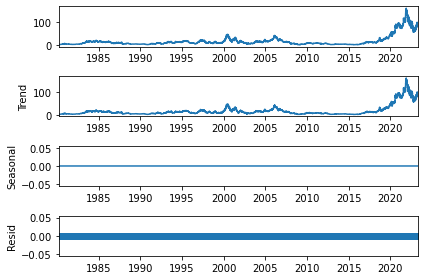

In [134]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(new.iloc[:,4:5], model="additive", period=1)
decompose_data.plot();

# Split into train and test

In [92]:
# Split data into training and testing sets
new = amd
#new.index = pd.to_datetime(new.Date)
train_size = int(len(new) * 0.8)
train, test = new['Close'].iloc[:train_size], new['Close'].iloc[train_size:]
print(train.shape)
print(test.shape)

(8687,)
(2172,)


# Model training

In [93]:
# Fitting the model

best_model = SARIMAX(train).fit(order=(1, 1, 1),seasonal_order=(1,1,1,12),enforce_stationarity=False,
                                enforce_invertibility=False,dis=-1)
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 8687
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -6292.598
Date:                Fri, 28 Apr 2023   AIC                          12589.195
Time:                        12:21:47   BIC                          12603.335
Sample:                             0   HQIC                         12594.015
                               - 8687                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9993      0.000   4712.134      0.000       0.999       1.000
sigma2         0.2491      0.001    244.365      0.000       0.247       0.251
Ljung-Box (L1) (Q):                   4.55   Jarque-

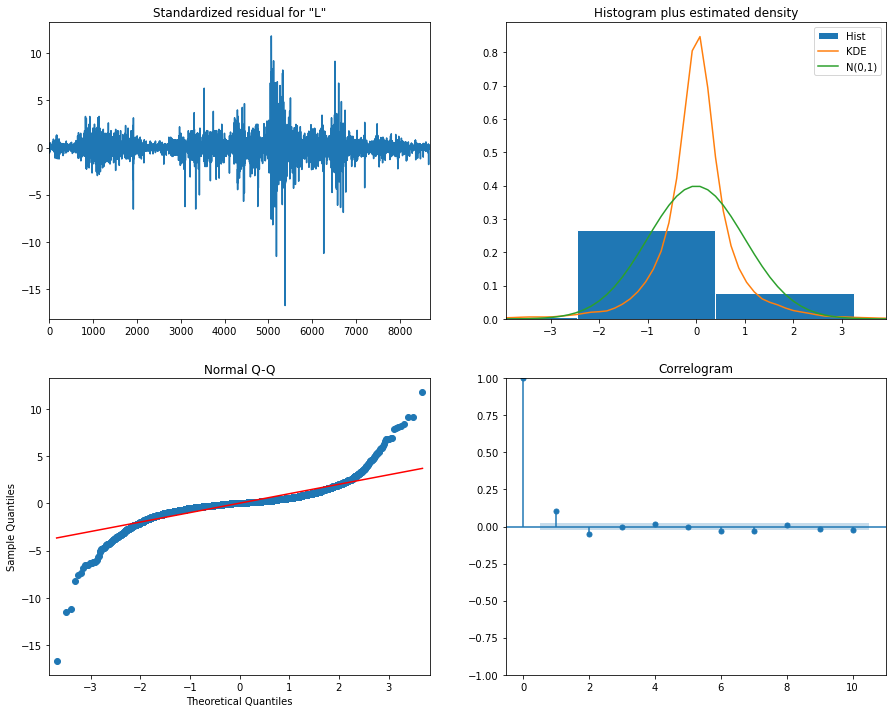

In [84]:
# Model Diagnostics
best_model.plot_diagnostics(figsize=(15,12));

In [78]:
train

0       2.937500
1       3.020833
2       3.010417
3       2.906250
4       2.635417
          ...   
8682    4.200000
8683    4.220000
8684    4.210000
8685    4.210000
8686    4.180000
Name: Low, Length: 8687, dtype: float64

In [79]:
test

8687      4.130000
8688      4.150000
8689      4.070000
8690      4.140000
8691      4.150000
           ...    
10854    91.360001
10855    90.620003
10856    91.019997
10857    92.690002
10858    91.739998
Name: Low, Length: 2172, dtype: float64

In [64]:
f

Date
2014-08-01    3.777498
2014-08-04    3.867439
2014-08-05    3.927399
2014-08-06    3.967373
2014-08-07    4.027333
2014-08-08    4.067307
2014-08-11    4.047320
2014-08-12    3.987359
2014-08-13    4.077300
2014-08-14    4.027333
2014-08-15    4.077300
2014-08-18    4.067307
2014-08-19    4.137260
2014-08-20    4.197220
2014-08-21    4.217207
2014-08-22    4.207214
2014-08-25    4.207214
Name: predicted_mean, dtype: float64

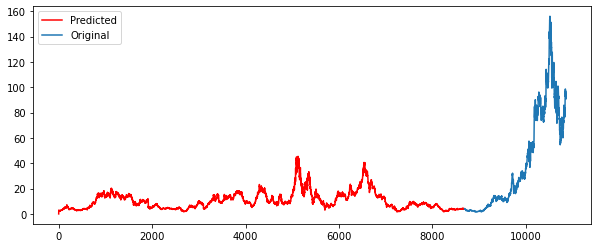

In [91]:
#f = best_model.get_forecast(start='2014-08-26', end='2023-04-12')
#f = best_model.get_forecast(steps=10)
f = best_model.predict(start=0,end= 8687)
#f.index = test.index
#f = test['sarima_model'].append(f)
plt.figure(figsize=(10,4))
plt.plot(f, color='r', label='model')
plt.plot(test, label='actual')
plt.legend(['Predicted','Original'])

In [19]:
help(best_model.get_forecast)

Help on method get_forecast in module statsmodels.tsa.statespace.mlemodel:

get_forecast(steps=1, **kwargs) method of statsmodels.tsa.statespace.sarimax.SARIMAXResults instance
    Out-of-sample forecasts and prediction intervals
    
    Parameters
    ----------
    steps : int, str, or datetime, optional
        If an integer, the number of steps to forecast from the end of the
        sample. Can also be a date string to parse or a datetime type.
        However, if the dates index does not have a fixed frequency, steps
        must be an integer. Default
    **kwargs
        Additional arguments may required for forecasting beyond the end
        of the sample. See `FilterResults.predict` for more details.
    
    Returns
    -------
    forecasts : PredictionResults
        PredictionResults instance containing out-of-sample forecasts and
        results including confidence intervals.
    
    See also
    --------
    forecast
        Out-of-sample forecasts.
    predict
     